In [1]:
import pandas as pd

booru_csv_path = "./data/safebooru-pic-meta/all_data.csv"

In [2]:
df = pd.read_csv(booru_csv_path)

df.head()

,id,created_at,rating,score,sample_url,sample_width,sample_height,preview_url,tags
0,1,1264803292,s,37,//safebooru.org/samples/1/sample_e7b3dc281d431...,850,638,//safebooru.org/thumbnails/1/thumbnail_e7b3dc2...,1girl bag black_hair blush bob_cut bowieknife ...
1,2,1264803292,s,12,//safebooru.org/samples/1/sample_27ff11b17a2c3...,850,1208,//safebooru.org/thumbnails/1/thumbnail_27ff11b...,barding black cape celty_sturluson dress dulla...
2,3,1264803298,s,8,//safebooru.org/samples/1/sample_ebd16eb1d1547...,850,599,//safebooru.org/thumbnails/1/thumbnail_ebd16eb...,blue_eyes blush brown_hair original scan takoy...
3,4,1264803299,s,5,//safebooru.org/samples/1/sample_6fbb9a4b9099e...,850,519,//safebooru.org/thumbnails/1/thumbnail_6fbb9a4...,game_cg hagall_valkyr mecha_musume shirogane_n...
4,6,1264803304,s,11,//safebooru.org/samples/1/sample_113cb63dc5412...,850,601,//safebooru.org/thumbnails/1/thumbnail_113cb63...,blush idolmaster kisaragi_chihaya komi_zumiko ...


In [3]:
print(df.shape[0])

3020460


In [4]:
# df.sort_values("score",ascending=False, inplace=True)
df = df.sample(frac=1,random_state=233).reset_index(drop=True)

In [5]:
df1=df[:80000]
tagdict={}
def replace_tagname(t):
    if(t=="touhou_(pc-98)"):
        return "touhou"
    
print(df1.shape[0])
for i in range(df1.shape[0]):
    tags = df1.iloc[i]["tags"]
    for t in tags.split(" "):
        if(t not in tagdict):
            tagdict[t]=0
        tagdict[t]+=1
print(len(tagdict))


80000
84440


In [6]:
if("highres" in tagdict):
    del tagdict["highres"]
top_tag_ls =[k for k in tagdict]
top_tag_ls.sort(key=lambda key:tagdict[key],reverse=True)#sory by frequency
for i in range(10):
    print("{}-{}".format(top_tag_ls[i],tagdict[top_tag_ls[i]]))

import json
# labels_path = "./safebooru-labels-topx.json"
# with open(labels_path,"w") as fp1:
#     json.dump(top_tag_ls[:50],fp1)
# print("saved to {}".format(labels_path))

labels_dict_path = "./safebooru-labels-dict.json"

labels_dict={k:i for i,k in enumerate(top_tag_ls[:50])}   #encoding labels to number, for classification

print(labels_dict)
with open(labels_dict_path,"w") as fp1:
    json.dump(labels_dict,fp1)
print("saved to {}".format(labels_dict_path))




solo-37513
1girl-36681
long_hair-34341
smile-23436
short_hair-21157
looking_at_viewer-19533
blush-19197
open_mouth-16537
breasts-16065
blue_eyes-15097
{'solo': 0, '1girl': 1, 'long_hair': 2, 'smile': 3, 'short_hair': 4, 'looking_at_viewer': 5, 'blush': 6, 'open_mouth': 7, 'breasts': 8, 'blue_eyes': 9, 'blonde_hair': 10, 'skirt': 11, 'brown_hair': 12, 'touhou': 13, 'multiple_girls': 14, 'hat': 15, 'black_hair': 16, 'red_eyes': 17, 'dress': 18, 'simple_background': 19, 'ribbon': 20, 'gloves': 21, 'hair_ornament': 22, 'bangs': 23, 'thigh-highs': 24, 'bow': 25, 'white_background': 26, 'brown_eyes': 27, 'school_uniform': 28, 'twintails': 29, 'original': 30, 'long_sleeves': 31, 'shirt': 32, 'eyebrows_visible_through_hair': 33, 'green_eyes': 34, 'translation_request': 35, 'kantai_collection': 36, 'sitting': 37, 'blue_hair': 38, 'commentary_request': 39, '2girls': 40, 'weapon': 41, 'animal_ears': 42, 'very_long_hair': 43, 'monochrome': 44, 'jewelry': 45, 'absurdres': 46, 'bare_shoulders': 47, 

In [7]:
#load
# labels_path = "./safebooru-labels-topx.json"
# with open(labels_path,"r") as fp1:
#     top_tag_ls = json.load(fp1)
# print(top_tag_ls)
tagset = set(labels_dict)
def select_criteria(tags):
    taghit=0
    tags = tags.split(" ")
    if(len(tags)<20):#select picture has more than y tags
        return False
    for t in tags:
        if(t in tagset):
            taghit+=1
    if(taghit>20):
        return True
    return False


df2 = df.loc[df['tags'].apply(select_criteria) == True]
print(df2.shape)

(10897, 9)


In [8]:
import requests
from PIL import Image
from tqdm import tqdm
import os

IMG_SIZE=(512, 384)
def resize_img(src_fn):
    # Opens a image in RGB mode  
    im = Image.open(src_fn) 

    #print("original size:{}".format(im.size))
    newsize = IMG_SIZE
    im1 = im.resize(newsize)
    #print("new size:{}".format(im1.size))
    im1.save(src_fn)

def gen_label_for_img(tags):
    #use labels_dict[tagname]
    tags = tags.split(" ")
    taglabel=[0]*len(labels_dict)
    for t in tags:
        if(t in labels_dict):
            taglabel[labels_dict[t]]=1
    return taglabel
    
headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"}
listfile = "./data/safebooru-pic-meta/list.json"
dataset={}

#for i in tqdm (range (100), desc="Loading..."):
for i in tqdm (range(df2.shape[0]), desc="Loading..."):
    fn = "./data/safebooru-pic-meta/pics/f_{}.jpg".format(i)

    
    url = df2.iloc[i]["sample_url"]
    if(url.startswith("//")):
        url = "http:{}".format(url)
    if(url.startswith("http://")):
        pass
    if(url.startswith("https://")):
        pass
    if(url.endswith(".png")):
        continue
    #print(url)
    tags = df2.iloc[i]["tags"]
    try:
        resp = requests.get(url,headers=headers)
        if(resp.status_code!=200):#error
            continue
        if(len(resp.content)<100):#too little, not image
            continue
        with open(fn,'wb') as fp1:
            fp1.write(resp.content)
        resize_img(fn)
    except Exception as e:
        print("Exception at file {}: {}".format(i,e))
        continue
    
    y=gen_label_for_img(tags)
    dataset[fn]=y
    
print(len(dataset))
print("crawler complete.")

Loading...:  18%|███████████▍                                                   | 1982/10897 [17:42<1:24:25,  1.76it/s]

Exception at file 1981: cannot write mode P as JPEG


Loading...:  33%|████████████████████▊                                          | 3597/10897 [32:22<1:31:11,  1.33it/s]

Exception at file 3596: cannot write mode P as JPEG


Loading...:  63%|███████████████████████████████████████▉                       | 6899/10897 [1:02:37<27:49,  2.40it/s]

Exception at file 6898: cannot write mode P as JPEG


Loading...:  78%|███████████████████████████████████████████████▋             | 8511/10897 [1:17:18<1:24:52,  2.13s/it]

Exception at file 8510: cannot write mode P as JPEG


Loading...:  85%|█████████████████████████████████████████████████████▍         | 9240/10897 [1:24:11<14:01,  1.97it/s]

Exception at file 9239: cannot write mode P as JPEG


Loading...:  86%|██████████████████████████████████████████████████████▏        | 9363/10897 [1:25:12<10:18,  2.48it/s]

Exception at file 9362: cannot write mode P as JPEG


Loading...:  99%|█████████████████████████████████████████████████████████████▍| 10792/10897 [1:39:00<00:55,  1.90it/s]

Exception at file 10791: cannot write mode P as JPEG


Loading...: 100%|██████████████████████████████████████████████████████████████| 10897/10897 [1:39:58<00:00,  1.82it/s]

7151
crawler complete.


In [9]:
with open(listfile,"w") as fp1:
    json.dump(dataset,fp1)
print("dumped manifest to {}".format(listfile))

dumped manifest to ./data/safebooru-pic-meta/list.json


//safebooru.org/samples/57/sample_04d208e032a49bf01e0e45eb62f70e6e8579ddc6.png
{0: 'solo', 1: '1girl', 2: 'long_hair', 3: 'smile', 4: 'short_hair', 5: 'looking_at_viewer', 6: 'blush', 7: 'open_mouth', 8: 'breasts', 9: 'blue_eyes', 10: 'blonde_hair', 11: 'skirt', 12: 'brown_hair', 13: 'touhou', 14: 'multiple_girls', 15: 'hat', 16: 'black_hair', 17: 'red_eyes', 18: 'dress', 19: 'simple_background', 20: 'ribbon', 21: 'gloves', 22: 'hair_ornament', 23: 'bangs', 24: 'thigh-highs', 25: 'bow', 26: 'white_background', 27: 'brown_eyes', 28: 'school_uniform', 29: 'twintails', 30: 'original', 31: 'long_sleeves', 32: 'shirt', 33: 'eyebrows_visible_through_hair', 34: 'green_eyes', 35: 'translation_request', 36: 'kantai_collection', 37: 'sitting', 38: 'blue_hair', 39: 'commentary_request', 40: '2girls', 41: 'weapon', 42: 'animal_ears', 43: 'very_long_hair', 44: 'monochrome', 45: 'jewelry', 46: 'absurdres', 47: 'bare_shoulders', 48: '1boy', 49: 'hair_ribbon'}
rows=5,cols=5


<Figure size 1500x1500 with 0 Axes>

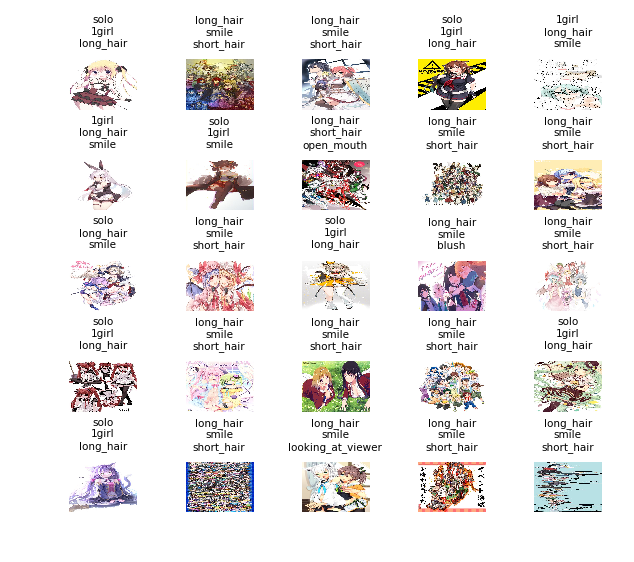

In [24]:
#take a look at sample images
import utils
import random
import numpy as np

import importlib
importlib.reload(utils)

random.seed(233)
print(df2.iloc[3348]["sample_url"])
subset = random.sample(list(dataset),25)

#print(subset)
img_list = []
tag_list=  []
labels_dict_rev = {labels_dict[k]:k for k in labels_dict}
print(labels_dict_rev)
for fn in subset:
    img_bytes = Image.open(fn)
    img=(np.array(img_bytes)/255.0).astype(np.float32)
    img_list.append(img)
    tags=dataset[fn]
    
    tag_list.append(tags)

utils.show_imgs_multi_label(data=img_list,real_labels=tag_list,classes_rev=labels_dict_rev,dispMax=3)
